In [1]:
from PIL import Image
from ultralytics import YOLO
from ultralytics.yolo.utils.ops import crop_mask, clip_segments
import numpy as np
import pandas as pd
from copy import deepcopy

/home/riccardo/anaconda3/envs/siv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
model = YOLO("yolov8n-seg.pt")

In [4]:
image = cv2.imread('people_test.jpg')

In [5]:
frame = deepcopy(image)

In [6]:
results = model.predict(image, save=False)

Ultralytics YOLOv8.0.24 🚀 Python-3.9.16 torch-1.13.1+cu117 CPU
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

0: 256x640 6 persons, 322.0ms
Speed: 2.7ms pre-process, 322.0ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
results = results[0]

In [8]:
masks = results.masks.masks.numpy()
boxes = results.boxes.xyxy.numpy()

In [37]:
def crop_segmentation(segment,box,image):
    img = image.copy()
    box = box.astype(int)
    w,h,c = img.shape
    mask = (cv2.resize(segment,(h,w)) > 0).astype("uint8")
    img_segm = cv2.bitwise_and(img,img,mask=mask)
    img_segm = img_segm[box[1]:box[3],box[0]:box[2]]
    return cv2.cvtColor(img_segm, cv2.COLOR_BGR2RGB)


0


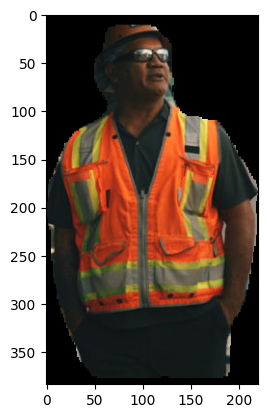

1


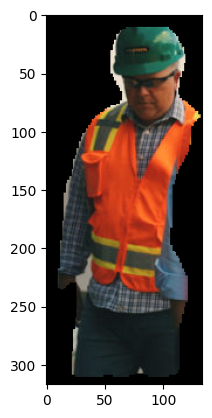

2


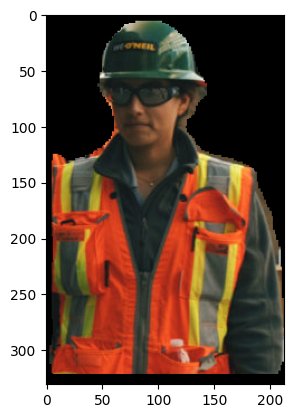

3


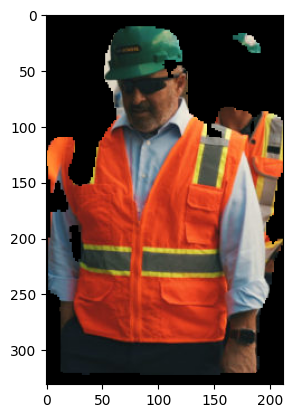

4


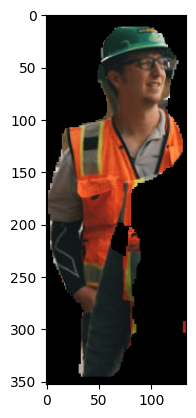

5


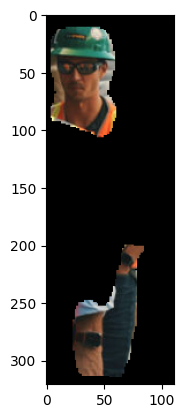

In [16]:
for i in range(len(boxes)):
    print(i)
    plt.imshow(crop_segmentation(masks[i],boxes[i],frame))
    plt.show()

In [52]:
from torchvision import transforms

In [56]:
preprocess = transforms.Compose([
            transforms.Resize((128,64)),
            # transforms.ToTensor()
        ])

In [46]:
cropped = [crop_segmentation(i[0],i[1],frame) for i in zip(masks,boxes)]

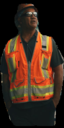

In [57]:
preprocess(Image.fromarray(cropped[0]))

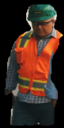

In [68]:
preprocess(Image.fromarray(cropped[1]))

In [60]:
from model.SiameseReId import SiameseReId

In [63]:
siamese_net = SiameseReId(os.path.join('model','weights','model_final.pt'))

In [ ]:
df = pd.DataFrame(columns=["features"])

print(df)

detections = np.random.randint(100, size=4)
print("Images: ", detections, "\n")

for det in detections:
    similarities = pd.DataFrame(columns=["track_id", "prob"])
    print("Detected image: ", det, "\n")

    vector = np.random.randint(100, size=4) # torch.model.densnet1(det) dall'immagine estrapolo il feature vector

    if df.empty:
        # vector = np.random.randint(100, size=4) # torch.model.densnet1(det) dall'immagine estrapolo il feature vector
        df = pd.concat([df, pd.DataFrame({"features": [vector]})], ignore_index=True) # salvo il feature vector
        print("Primo inserimento Dataframe: \n", df)
    else:
        # vector =  np.random.randint(100, size=4) # torch.model.densnet1(det
        for id, row in df.iterrows(): # da ottimizzare con vec o vec_numpy o apply
            prob = np.random.rand(1,1)[0] # snn_model(row, det)
            similarities = pd.concat([similarities, pd.DataFrame({"track_id": id, "prob": prob})], ignore_index=True)
            print(similarities, "\n")

        # print(similarities["prob"].max(), similarities["prob"].idxmax())
        track_id = similarities["prob"].idxmax()

        if similarities.iloc[track_id]["prob"] > 0.9: # nel caso aggiorniamo le features con quelle nuove trovate?
            print("TROVATO: ", det, " ==> ", track_id, "\n")
        # print(similarities.iloc[track_id]["features"])
        else:
            df = pd.concat([df, pd.DataFrame({"features": [vector]})], ignore_index=True)
        print(df, "\n")

In [5]:
model.predict("0",show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.24 🚀 Python-3.9.16 torch-1.13.1+cu117 CPU
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs

1/1: 0...  Success (inf frames 640x480 at 30.00 FPS)

0: 480x640 1 person, 7 chairs, 1 tv, 385.7ms
0: 480x640 1 person, 8 chairs, 1 tv, 341.1ms
0: 480x640 1 person, 7 chairs, 1 tv, 310.4ms
0: 480x640 1 person, 8 chairs, 1 tv, 1 laptop, 279.7ms
0: 480x640 1 person, 8 chairs, 2 tvs, 339.8ms
0: 480x640 1 person, 7 chairs, 1 tv, 298.2ms
0: 480x640 1 person, 7 chairs, 2 tvs, 350.9ms
0: 480x640 1 person, 7 chairs, 1 tv, 282.0ms
0: 480x640 1 person, 8 chairs, 1 tv, 695.7ms
0: 480x640 1 person, 7 chairs, 1 tv, 1 laptop, 428.1ms
0: 480x640 1 person, 7 chairs, 2 tvs, 1 laptop, 462.4ms
0: 480x640 1 person, 8 chairs, 2 tvs, 328.3ms
0: 480x640 1 person, 8 chairs, 2 tvs, 352.3ms
0: 480x640 1 person, 7 chairs, 1 tv, 304.7ms
0: 480x640 1 person, 6 chairs, 2 tvs, 1 laptop, 379.8ms
0

KeyboardInterrupt: 